# Train DECIPHER model

> (Estimated time: ~5 min with GPU)

In this vignette, we show how to train `DECIPHER` model on spatial omics data to obtain disentangled omics and spatial embedding. We have following steps:

1. Init model
2. Register data
3. Fit model
4. Visualize results



In [1]:
import scanpy as sc

from decipher import DECIPHER
from decipher.utils import scanpy_viz

/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/cudf/utils/gpu_utils.py:149: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
2025-07-11 15:51:12.028 | WARNING  | decipher.utils:<module>:34 - Rapids not avaliable, use Scanpy


In [2]:
sc.set_figure_params(dpi=80)

## Step 1: Init model
Init the model with a self-defined work_dir. It's better to have a directory that doesn't exist yet, `DECIPHER` will create it and save the model, log and embedding files in it.

In [3]:
# model = DECIPHER(work_dir='/path/to/work_dir')
model = DECIPHER(work_dir='./decipher')

2025-07-11 15:51:14.611 | WARNING  | decipher.cls:__init__:47 - decipher already exists but `recover` is False.
2025-07-11 15:51:14.628 | SUCCESS  | decipher.utils:global_seed:330 - Global seed set to 0.


## Step 2: Register data

`DECIPHER` expect spatial omics data in`AnnData` object (or list of `AnnData`, see advanced topics) as input. The expression matrix should be raw counts (not log-normalized or scaled). And spatial coordinates should be saved in `adata.obsm['spatial']` slot.

> See `AnnData` [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct `AnnData` objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into `AnnData` objects.

Here we use a simulation dataset as an toy example, you can download it from [Google Drive](https://drive.google.com/file/d/10YpaS46z6GayE6WhtMUEq2OAa-u6C1fJ/view?usp=sharing).

In [4]:
# adata = sc.read_h5ad('/path/to/adata.h5ad')
adata = sc.read_h5ad('./adata.h5ad')
adata

AnnData object with n_obs × n_vars = 4512 × 31915
    obs: 'batch', 'leiden', 'cell_type', 'group', 'region'
    var: 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'gene_ids-0', 'gene_ids-1'
    uns: 'Reigon_colors', 'cell_type_colors', 'group_colors', 'region_colors', 'reigon_colors'
    obsm: 'spatial'

There are three cell types in the dataset
- T cell (CD3D+)
- B cell (CD79A+)
- Monocyte (CD14+)

We simulated three different spatial patterns:
- region 1: T cell & Monocyte mixed
- region 2: T cell only
- region 3: T cell & B cell mixed

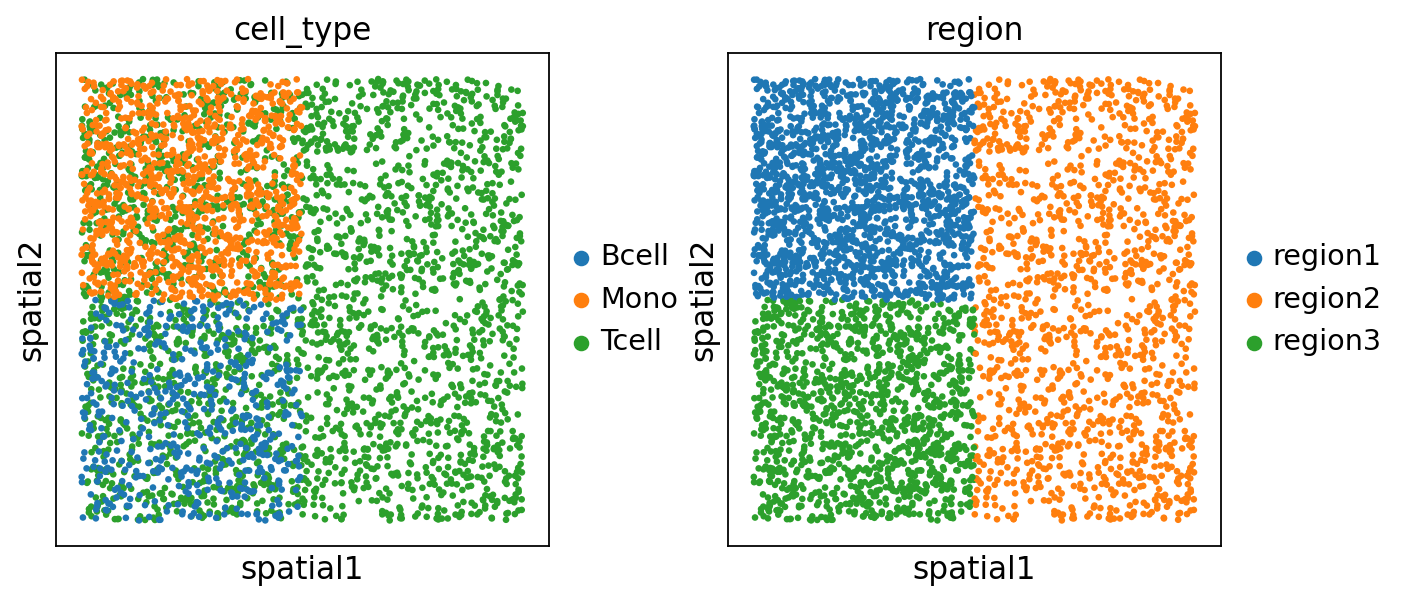

In [5]:
sc.pl.spatial(adata, color=['cell_type', 'region'], spot_size=0.03)

We need register the data to our model, it will automatically preprocess the data.

In [6]:
model.register_data(adata)

2025-07-11 15:51:15.819 | DEBUG    | decipher.data.process:omics_data_process:68 - adata 0 has 4512 cells, 31915 genes.
2025-07-11 15:51:15.821 | INFO     | decipher.data.process:omics_data_process:86 - Input: 1 slice(s) with 4512 cells and 1 batches.
2025-07-11 15:51:15.821 | INFO     | decipher.data.process:_preprocess_adata:98 - Preprocessing 4512 cells.
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-07-11 15:51:54.460 | SUCCESS  | decipher.data.process:_preprocess_adata:148 - Preprocessing finished in 38.64 seconds.
2025-07-11 15:51:55.514 | SUCCESS  | decipher.graphic.build:build_graph:102 - Built knn graph with 4512 nodes and 90240 edges, 20.00 edges/node.


## Step 3: Fit model

Then we fit DECIPHER model:

In [7]:
model.fit_omics()

2025-07-11 15:51:55.565 | INFO     | decipher.emb:load_sc_model:189 - Loading model from decipher/pretrain/epoch=2-step=51.ckpt
2025-07-11 15:51:56.555 | DEBUG    | decipher.nn.models._basic:__init__:31 - {'model_dir': 'pretrain', 'fix_sc': False, 'spatial_emb': 'attn', 'transformer_layers': 3, 'num_heads': 1, 'dropout': 0.1, 'prj_dims': [128, 32, 32], 'temperature_center': 0.07, 'temperature_nbr': 0.07, 'lr_base': 0.01, 'lr_min': 0.001, 'weight_decay': 1e-05, 'first_cycle_steps': 99999, 'warmup_steps': 200, 'epochs': 3, 'nbr_loss_weight': 0.5, 'plot': False, 'plot_hist': False, 'device': 'auto', 'select_gpu': True, 'device_num': 1, 'fp16': True, 'patient': 10, 'log_every_n_steps': 1, 'gradient_clip_val': 5.0, 'check_val_every_n_epoch': 1, 'max_steps': 10000, 'augment': {'dropout_gex': 0.5, 'dropout_nbr_prob': -1, 'mask_hop': -1, 'max_neighbor': 21}, 'emb_dim': 128, 'gex_dims': [-1, 256, 128], 'work_dir': './decipher', 'force': False}
2025-07-11 15:51:56.565 | SUCCESS  | decipher.emb:l

Training: |          | 0/? [00:00<?, ?it/s]

Metric train/total_loss improved. New best score: 2.855
Metric train/total_loss improved by 0.127 >= min_delta = 0.0. New best score: 2.729
Metric train/total_loss improved by 0.136 >= min_delta = 0.0. New best score: 2.592
Metric train/total_loss improved by 0.101 >= min_delta = 0.0. New best score: 2.491
Metric train/total_loss improved by 0.003 >= min_delta = 0.0. New best score: 2.488
Metric train/total_loss improved by 0.051 >= min_delta = 0.0. New best score: 2.437
`Trainer.fit` stopped: `max_steps=102` reached.
2025-07-11 15:52:17.147 | SUCCESS  | decipher.nn.trainer:fit:112 - Train finished in 20.36s.


Testing: |          | 0/? [00:00<?, ?it/s]

2025-07-11 15:52:18.469 | INFO     | decipher.cls:fit_omics:175 - Results saved to decipher


After training, we can extract disentangled omics and spatial embeddings from model:

In [8]:
gex_embedding = model.center_emb
nbr_embedding = model.nbr_emb

## Step 4: Visualize results

At last we cluster and visualize the embeddings.

In [9]:
adata.obsm['X_center'] = gex_embedding
adata.obsm['X_nbr'] = nbr_embedding
adata = scanpy_viz(adata, ['center', 'nbr'], rapids=False)

/flash/grp/gglab/xiacr/DECIPHER-dev/decipher/utils.py:649: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc_.tl.leiden(adata, resolution=resolution)


In [10]:
adata

AnnData object with n_obs × n_vars = 4512 × 2000
    obs: 'batch', 'leiden', 'cell_type', 'group', 'region', '_group', 'leiden_center', 'leiden_nbr'
    var: 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'gene_ids-0', 'gene_ids-1'
    uns: 'Reigon_colors', 'cell_type_colors', 'group_colors', 'region_colors', 'reigon_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_center', 'X_nbr', 'X_umap_center', 'X_umap_nbr'

Firstly, we check the omics embedding, we found it matches the cell type ground truth well.

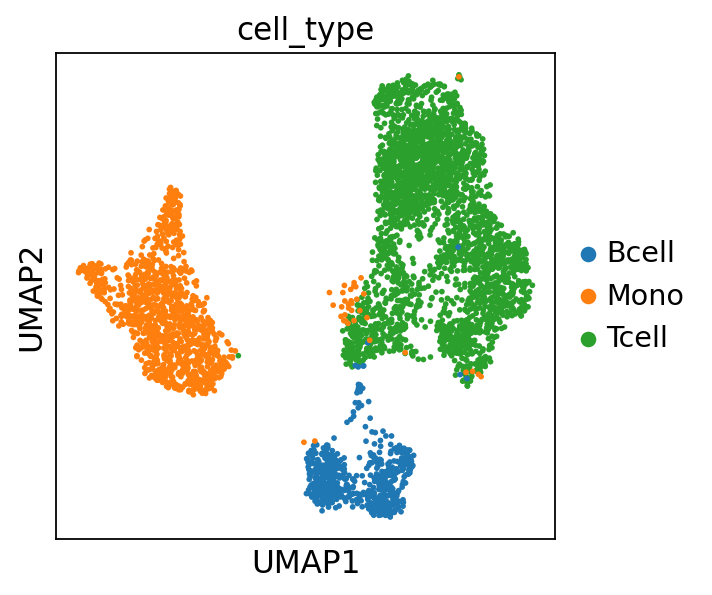

In [11]:
adata.obsm['X_umap'] = adata.obsm['X_umap_center'].copy()
sc.pl.umap(adata, color=['cell_type'])

Then we check the spatial embedding, we found it matches the spatial patterns ground truth well.


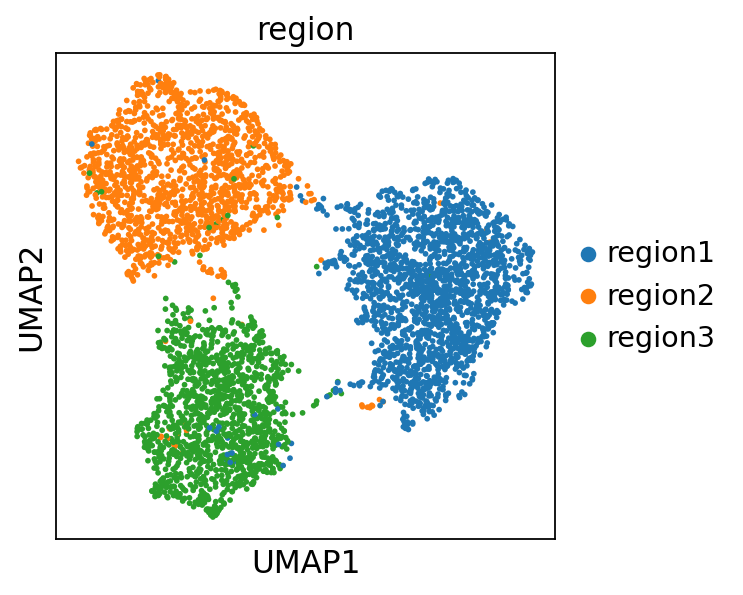

In [12]:
adata.obsm['X_umap'] = adata.obsm['X_umap_nbr'].copy()
sc.pl.umap(adata, color=['region'])